# Provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such  situations is part of the challenge.Minimize the error.

# Steps

Preprocessing and Cleaning->An intermediate master data frame which is
completely clean and incorporates all essential features.
EDA->Proper visualizations needed, with relevance to understanding how to best
predict the future sales.
Modelling and optimization of training accuracy

In [108]:
# import libraries
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller ,acf,pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats as sm
import scipy.stats as scs
import itertools 

In [68]:
# Import All Data
sales=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\sales_train.csv\\sales_train_v2.csv')
item_cate=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\item_categories.csv')
item=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\items.csv')
sample=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\sample_submission.csv')
shops=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\shops.csv')
test=pd.read_csv('C:\\Users\\sif-2880\\Downloads\\competitive-data-science-predict-future-sales\\test.csv')

In [69]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [70]:
item.head(4)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40


In [71]:
sample.head(4)

,ID,item_cnt_month
0,0,0.50
1,1,0.50
2,2,0.50
3,3,0.50


In [ ]:
# This are the transaction we will groupby from , + category_id

In [72]:
sales_new=pd.merge(sales,item,on='item_id',how='left')

In [73]:
sales_new=sales_new.drop('item_name',axis=1)
sales_new.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.00,37
1,03.01.2013,0,25,2552,899.00,1.00,58
2,05.01.2013,0,25,2552,899.00,-1.00,58
3,06.01.2013,0,25,2554,"1,709.05",1.00,58
4,15.01.2013,0,25,2555,"1,099.00",1.00,56


In [74]:
# Summary Statics of Training Data
pd.options.display.float_format='{:20,.2f}'.format
sales_new.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,"2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00"
mean,14.57,33.00,"10,197.23",890.85,1.24,40.00
std,9.42,16.23,"6,324.30","1,729.80",2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,"4,476.00",249.00,1.00,28.00
50%,14.00,31.00,"9,343.00",399.00,1.00,40.00
75%,23.00,47.00,"15,684.00",999.00,1.00,55.00
max,33.00,59.00,"22,169.00","307,980.00","2,169.00",83.00


In [76]:
sales_new['date_formatted'] = pd.to_datetime(sales_new.date, format="%d.%m.%Y")
sales_new[['day','month','year']] = sales_new.date.str.split('.',expand=True)
sales_new['sales'] = sales_new.item_price * sales_new.item_cnt_day

In [77]:
sales_new.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_formatted,day,month,year,sales
0,02.01.2013,0,59,22154,999.00,1.00,37,2013-01-02,02,01,2013,999.00
1,03.01.2013,0,25,2552,899.00,1.00,58,2013-01-03,03,01,2013,899.00
2,05.01.2013,0,25,2552,899.00,-1.00,58,2013-01-05,05,01,2013,-899.00
3,06.01.2013,0,25,2554,"1,709.05",1.00,58,2013-01-06,06,01,2013,"1,709.05"
4,15.01.2013,0,25,2555,"1,099.00",1.00,56,2013-01-15,15,01,2013,"1,099.00"


In [78]:
sales_new.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
date_formatted      0
day                 0
month               0
year                0
sales               0
dtype: int64

C:\Users\sif-2880\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


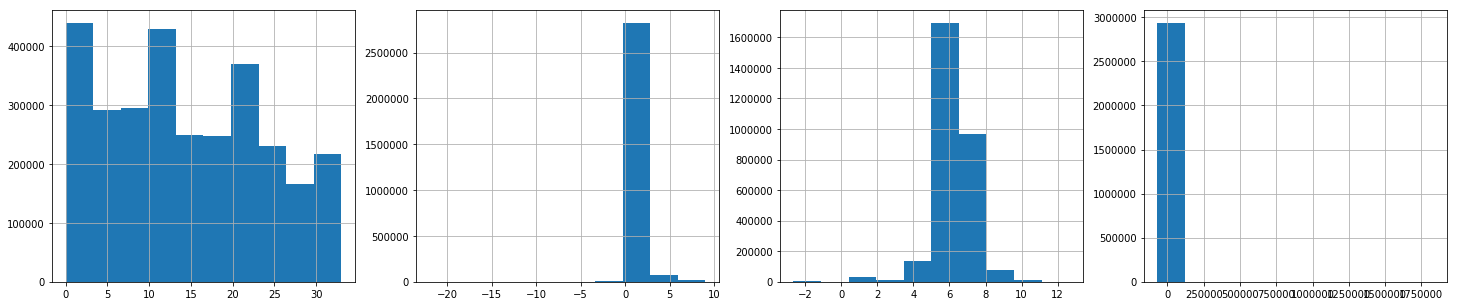

In [79]:
fig,axes=plt.subplots(1,4,figsize=(25,5))
sales_new.date_block_num.hist(ax=axes[0])
sales_new[sales_new['item_cnt_day']<10].item_cnt_day.hist(ax=axes[1])
np.log(sales_new['item_price']).hist(ax=axes[2])
sales_new.sales.hist(ax=axes[3])

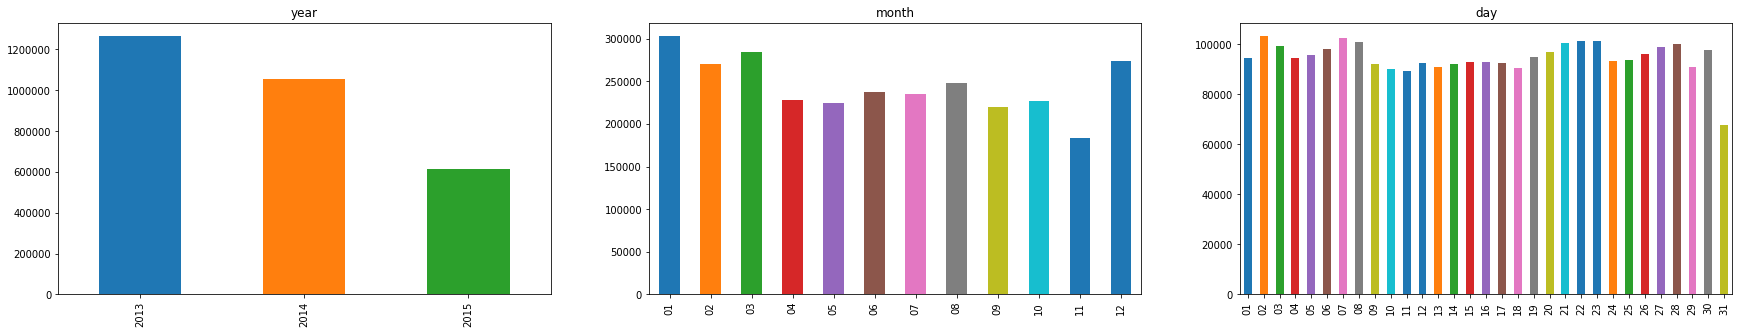

In [80]:
fig,axes=plt.subplots(1,3,figsize=(30,5))
sales_new['year'].value_counts().sort_index().plot.bar(ax=axes[0],title='year')
sales_new['month'].value_counts().sort_index().plot.bar(ax=axes[1],title='month')
sales_new['day'].value_counts().sort_index().plot.bar(ax=axes[2],title='day')

looks like number of sales data points has dropped each year and highest number of sales in januray and december due to christmas and new year

# Lets find the trend in the Data

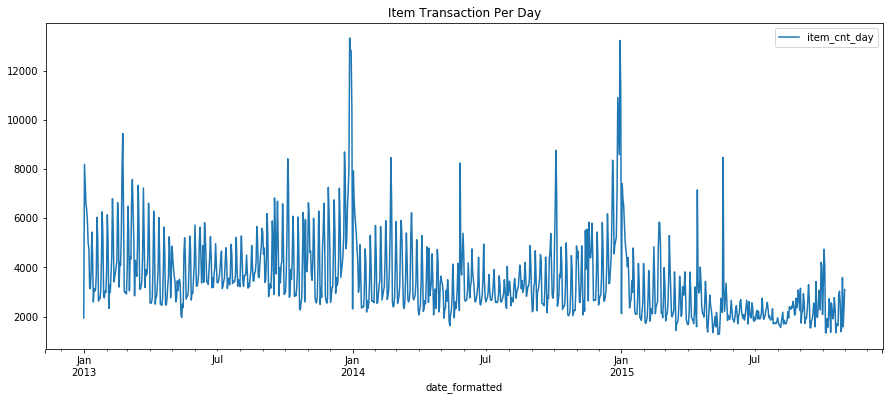

In [81]:
sales_new.groupby('date_formatted').agg({'item_cnt_day':'sum'}).plot(figsize=(15,6),title='Item Transaction Per Day')

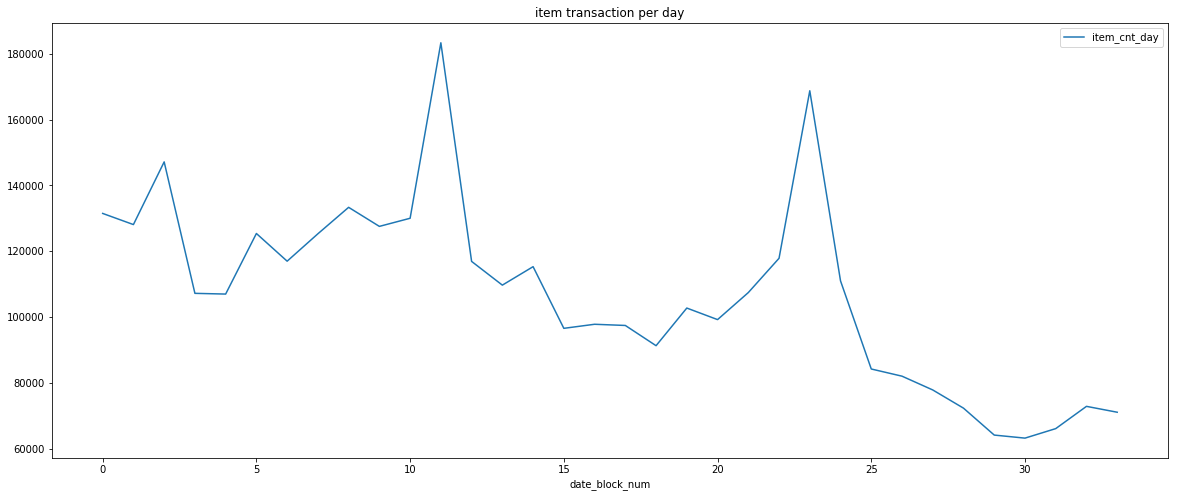

In [82]:
# sales trend in weekly
# Since the average daily item count per transaction is the same each year, it looks like the decline is due to the total number of transactions.
sales_new.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(20,8),title='item transaction per day')

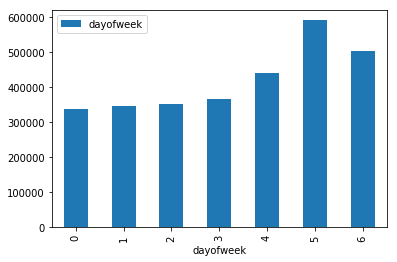

In [83]:
# Weekly Seasonality friday ,Saturday and Sunday 
sales_new['dayofweek']=sales_new.date_formatted.dt.dayofweek
sales_new.groupby('dayofweek').agg({'dayofweek':'count'}).plot.bar()

# A time series plot forecasting sales for the next 1 month using any method(eg ARIMA, Holt Winters , etc)

In [84]:
# Total Number of items 
sales_new['item_id'].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
7856      6602
3732      6475
2308      6320
4870      5811
3734      5805
1855      5681
5821      5389
16787     5283
6675      5122
7894      5107
2445      5056
1830      4976
5823      4974
6497      4904
5272      4853
13071     4804
6740      4675
3183      4615
4178      4527
2416      4487
7893      4380
6466      4324
6498      4278
6503      4274
6457      4269
         ...  
181          1
2647         1
599          1
21074        1
20670        1
601          1
14942        1
4278         1
596          1
595          1
19010        1
594          1
16255        1
7731         1
588          1
2636         1
184          1
21060        1
18290        1
4684         1
590          1
21061        1
183          1
15913        1
3628         1
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

# Let's forecast the Top two item_id(20949 , 5822) for next one month 

In [93]:
item_1=sales_new.loc[sales_new['item_id']==20949]
item_2=sales_new.loc[sales_new['item_id']==5822]

In [94]:
item_1.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_formatted,day,month,year,sales,dayofweek
352379,30.04.2013,3,22,20949,5.00,12.00,71,2013-04-30,30,04,2013,60.00,1
352399,29.04.2013,3,22,20949,4.92,13.00,71,2013-04-29,29,04,2013,64.00,0
352400,28.04.2013,3,22,20949,5.00,4.00,71,2013-04-28,28,04,2013,20.00,6


In [95]:
item_2.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,date_formatted,day,month,year,sales,dayofweek
1350,03.01.2013,0,25,5822,999.00,1.00,35,2013-01-03,03,01,2013,999.00,3
1380,10.01.2013,0,25,5822,999.00,1.00,35,2013-01-10,10,01,2013,999.00,3
1381,13.01.2013,0,25,5822,999.00,2.00,35,2013-01-13,13,01,2013,"1,998.00",6


In [96]:
# Min and Max Date
item_1['date_formatted'].min(), item_1['date_formatted'].max()

(Timestamp('2013-04-24 00:00:00'), Timestamp('2015-10-31 00:00:00'))

In [97]:
# Min and Max Date
item_2['date_formatted'].min(), item_2['date_formatted'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

In [98]:
# Item_1 (20949)
cols = ['date','date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id','day', 'month',
       'year','dayofweek']
item_1.drop(cols, axis=1, inplace=True)
item_1 = item_1.sort_values('date_formatted')
item_1.isnull().sum()

C:\Users\sif-2880\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


date_formatted    0
sales             0
dtype: int64

In [99]:
# Item_2(5822)
cols = ['date','date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id','day', 'month',
       'year','dayofweek']
item_2.drop(cols, axis=1, inplace=True)
item_2 = item_2.sort_values('date_formatted')
item_2.isnull().sum()

C:\Users\sif-2880\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


date_formatted    0
sales             0
dtype: int64

In [100]:
item_1=item_1.groupby('date_formatted')['sales'].sum().reset_index()

In [101]:
item_1=item_1.set_index('date_formatted')
item_1.index

DatetimeIndex(['2013-04-24', '2013-04-25', '2013-04-26', '2013-04-27',
               '2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01',
               '2013-05-02', '2013-05-03',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', name='date_formatted', length=921, freq=None)

In [102]:
y=item_1['sales'].resample('MS').mean()

In [103]:
y['2013':]

date_formatted
2013-04-01                 180.57
2013-05-01                 593.59
2013-06-01               1,394.49
2013-07-01               1,162.84
2013-08-01               1,169.10
2013-09-01               1,309.47
2013-10-01               1,235.50
2013-11-01               1,410.15
2013-12-01               2,006.94
2014-01-01               1,170.03
2014-02-01               1,158.97
2014-03-01               1,229.95
2014-04-01                 967.73
2014-05-01                 927.39
2014-06-01               1,106.49
2014-07-01                 953.36
2014-08-01               1,006.17
2014-09-01               1,087.82
2014-10-01               1,046.84
2014-11-01               1,277.18
2014-12-01               1,938.78
2015-01-01               1,232.45
2015-02-01                 551.76
2015-03-01                 307.40
2015-04-01                 680.50
2015-05-01                 606.40
2015-06-01                 578.29
2015-07-01                 538.32
2015-08-01                 571.32

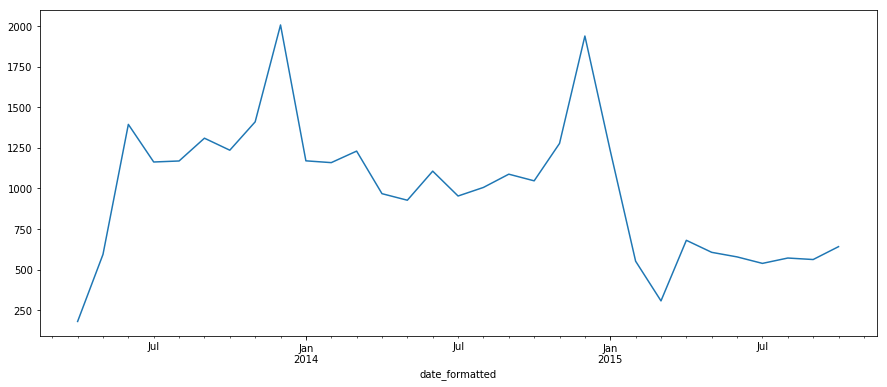

In [104]:
y.plot(figsize=(15,6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

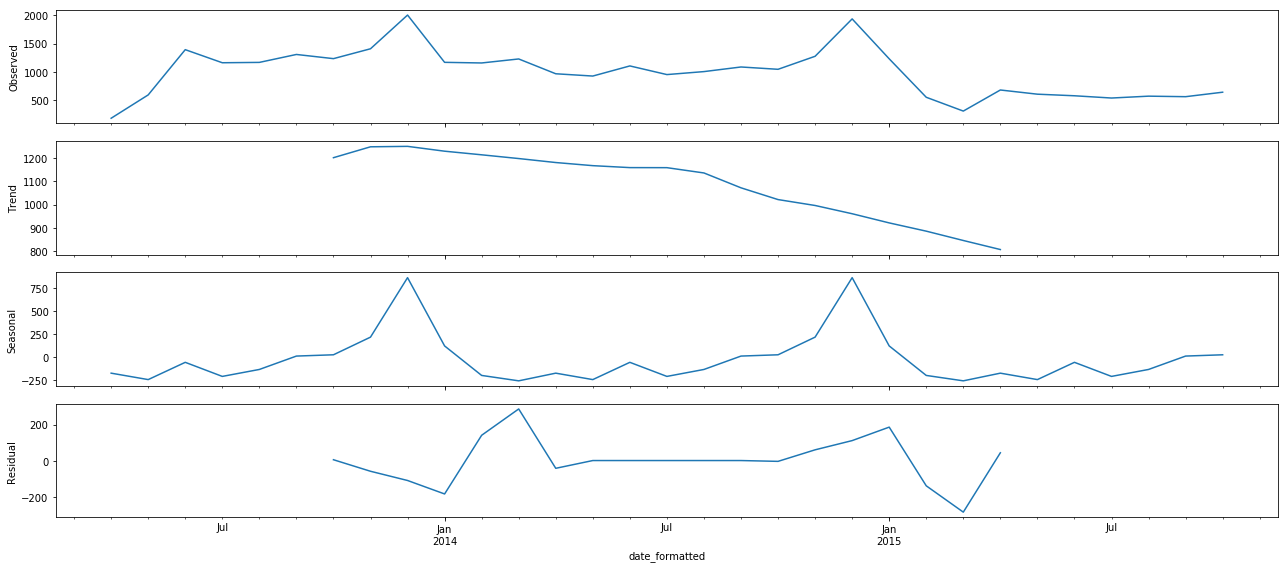

In [112]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize']=18,8

decomposition=sm.tsa.seasonal_decompose(y,model='additive')
fig=decomposition.plot()
plt.show()

Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:



In [113]:
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list (itertools.product(p,d,q))]

print('Example of parameter combinations for seasonal ARIMA..')
print('Sarimax: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('Sarimax: {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('Sarimax: {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('Sarimax: {} x {}'.format(pdq[2],seasonal_pdq[4]))

Example of parameter combinations for seasonal ARIMA..
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
Sarimax: (0, 0, 1) x (0, 1, 0, 12)
Sarimax: (0, 1, 0) x (0, 1, 1, 12)
Sarimax: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [114]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:506.68259288404846
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:268.6629272184286


C:\Users\sif-2880\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:277.99567972893203
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:108.44079972232196
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:464.63471752694613
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:239.88040863855727
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:265.52378707207436
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:101.61227101575014
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:424.57956264284314
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:243.32196595212895
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:254.5219728082582
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:73.37953105386089


C:\Users\sif-2880\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:406.33233877552254
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:226.0440388791602
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:253.03701192167344
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:73.05040616393579
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:440.8550945765405
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:256.77810068816774
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:249.66622663726508
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:73.76365864404468
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:426.92379656477584
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:239.16058668400947
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:247.5347197919732
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:76.02671909289914
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:426.5537129326121
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:245.2193547672062
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:241.88685072564664
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:62.825498103938905
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:406.2341162157473
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:227.0694603353029
AR

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 58.49. Therefore we should consider this to be optimal option.

Using AIC to Test ARIMA Models. The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”



In [117]:
# FITTING ARIMA MODEL 
mod=sm.tsa.statespace.SARIMAX(y,order=(1,1,1),seasonal_order=(1,1,0,12),enforce_stationarity=False,enforce_invertibility=False)

results=mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4928      0.687     -0.717      0.473      -1.839       0.853
ma.L1         -1.0000      0.996     -1.004      0.315      -2.952       0.952
ar.S.L12      -0.0678      0.034     -1.989      0.047      -0.135      -0.001
sigma2      1146.0666      0.001   1.32e+06      0.000    1146.065    1146.068


We should always run model diagnostics to investigate any unusual behavior.

ValueError: operands could not be broadcast together with shapes (9,) (3,) (9,) 

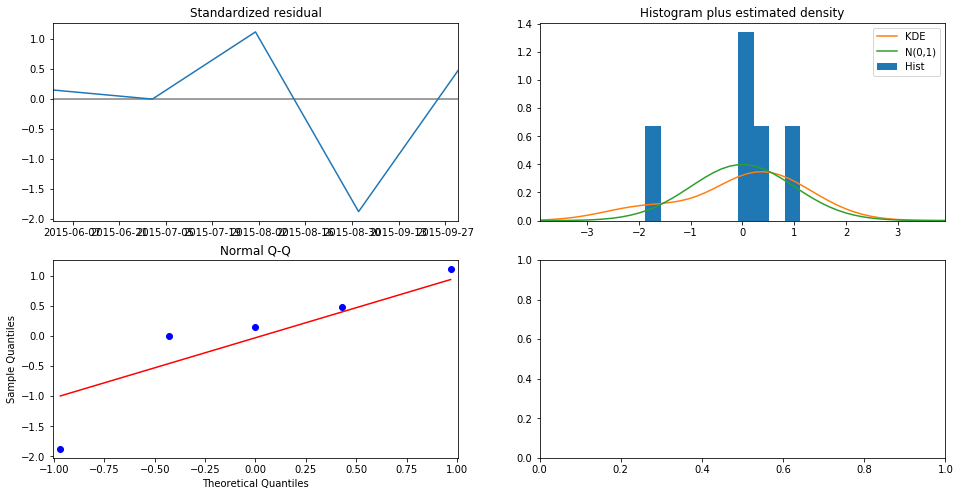

In [118]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

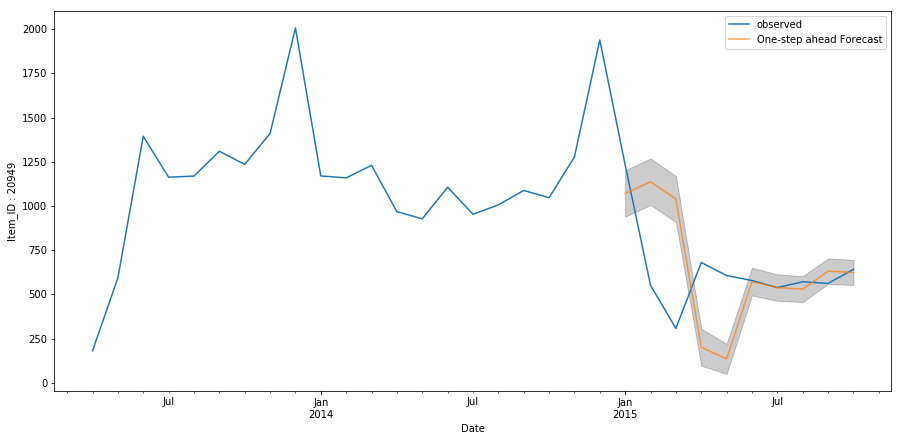

In [122]:
pred=results.get_prediction(start=pd.to_datetime('2015-01-01'),dynamic=False)
pred_ci=pred.conf_int()
ax=y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',alpha=0.7,figsize=(15,7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Item_ID : 20949')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [121]:
y_forecasted=pred.predicted_mean 
y_truth=y['2015-01-01':]
mse=((y_forecasted-y_truth)**2).mean()
print('The MEan Squared Error of our forcast is {}'.format(round(mse,2)))
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse),2)))

The MEan Squared Error of our forcast is 136349.26
The Root Mean Squared Error of our forecast is 369.26


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily (itemID 20949) sales in the test set within 369.26 of the real sales. Our (itemID 20949) daily sales range from around 180 to over 2000. In my opinion, this is a pretty good model so far.

Text(0,0.5,'Item_ID : 20949')

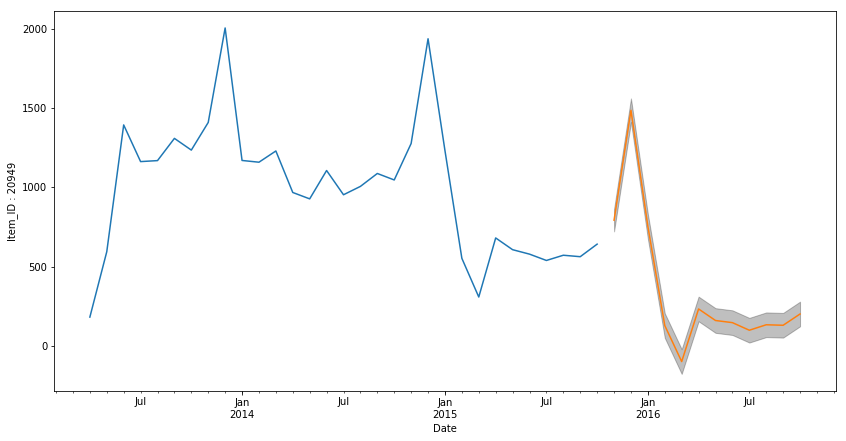

In [124]:
#Producing and Visualising Forecast 
pred_uc=results.get_forecast(steps=12)
pred_ci=pred_uc.conf_int()
ax=y.plot(label='observed',figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Item_ID : 20949')

In [126]:
# For Next One Year
pred_ci

,lower sales,upper sales
2015-11-01,721.91,863.12
2015-12-01,"1,411.94","1,561.90"
2016-01-01,675.57,831.25
2016-02-01,49.51,204.76
2016-03-01,-178.32,-22.28
2016-04-01,154.04,309.83
2016-05-01,81.06,237.01
2016-06-01,67.57,223.44
2016-07-01,19.64,175.55
2016-08-01,54.13,210.02
